In [66]:
import Utilities.prelude as prel
import numpy as np
import matplotlib.pyplot as plt

from Utilities.operators import make_tree

In [67]:
z_chosen = 0
mach_min = 1.3
gamma = 5/3
save = False
folder = 'sedov'
snap = '100'
path = f'{folder}/{snap}'

if folder == 'TDE':
    is_tde = True
    epsilon = 0.02
else:
    is_tde = False
    epsilon = 0.02

In [68]:
def soundspeed(gamma, pressure, density):
    cs = np.sqrt(gamma * pressure/density)
    return cs

def surface_area(volume):
    surf = volume**(2/3)
    return surf

def pressure_bump(mach):
    """ P_post/ P_pre shock"""
    Pbump = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1)
    return 

def density_bump(mach):
    """ rho_post/ rho_pre shock"""
    rhobump = (gamma+1) * mach**2 / ((gamma-1)*mach**2 + 2)
    return rhobump

def kinetic_enflux(gamma, P_pre, den_pre, mach):
    cs_pre = soundspeed(gamma, P_pre, den_pre)
    f_phi = 0.5 * den_pre * (cs_pre * mach)**3
    return f_phi

def efficiency(mach, R):
    # Eq.(8) from Schaal14
    delta = 2 / (gamma * (gamma-1) * mach**2 * R) * ((2*gamma*mach**2-(gamma-1))/(gamma+1) - R**gamma)
    return delta

def energy_flux(gamma, P_pre, den_pre, mach, R):
    # Eq.(7) from Schaal14
    delta = efficiency(mach, R)
    f_phi = kinetic_enflux(gamma, P_pre, den_pre, mach)
    f_th = delta * f_phi
    return f_th

def analytical_flux(e_pre, e_post, R, vel_post):
    f_analytical = (e_post - e_pre * R**gamma) * vel_post
    return f_analytical

In [69]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, IE, Den, Press, Temp = make_tree(path, snap, is_tde, int_energy = True)
V = np.sqrt(VX**2 + VY**2 + VZ**2)

all T=0, bro. Compute by myself!


In [70]:
# Import data
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

x_zone = shockzone[0]
y_zone = shockzone[1]
z_zone = shockzone[2]
idx_zone = shockzone[5]

idx_surf = shocksurface[0]
mach_shock = shocksurface[1]
mach_shockP = shocksurface[2]
mach_shockDen = shocksurface[3]
indeces_pre = shocksurface[4]
indeces_post = shocksurface[5]

In [71]:
idx_zone = [int(i) for i in idx_zone]
vol_zone = Vol[idx_zone]

In [72]:
if folder == 'sedov':
    idx_surf = [int(i) for i in idx_surf]
    x_surf = x_zone[idx_surf]
    y_surf = y_zone[idx_surf]
    z_surf = z_zone[idx_surf]
    vol_surface = vol_zone[idx_surf]
else: 
    x_surf = shocksurface[6]
    y_surf = shocksurface[7]
    z_surf = shocksurface[8]


In [73]:
flux = np.zeros(len(x_surf))
an_flux = np.zeros(len(x_surf))

for i in range(len(x_surf)):
    surf = surface_area(vol_surface[i])
    mach = mach_shock[i]
    machP = mach_shockP[i]
    machDen = mach_shockDen[i]
    R = density_bump(mach)
    idx_pre = int(indeces_pre[i])
    idx_post = int(indeces_post[i])
    # den_pre = Den[idx_post]/R
    # vel_post = V[idx_post]
    # ratioP = pressure_bump(mach)
    den_pre = Den[idx_pre]
    P_pre = Press[idx_pre]
    vel_post = V[idx_pre] * density_bump(machDen)
    f_th = energy_flux(gamma, P_pre, den_pre, mach, R)
    flux[i] = f_th
    f_an = analytical_flux(IE[idx_pre], IE[idx_post], R, vel_post)
    an_flux[i] = f_an
    

In [74]:
if folder == 'sedov':
    surface_cross_x = x_surf[np.abs(z_surf-z_chosen)<epsilon]
    surface_cross_y = y_surf[np.abs(z_surf-z_chosen)<epsilon]
    flux_cross = flux[np.abs(z_surf-z_chosen)<epsilon]
    an_flux_cross = an_flux[np.abs(z_surf-z_chosen)<epsilon]

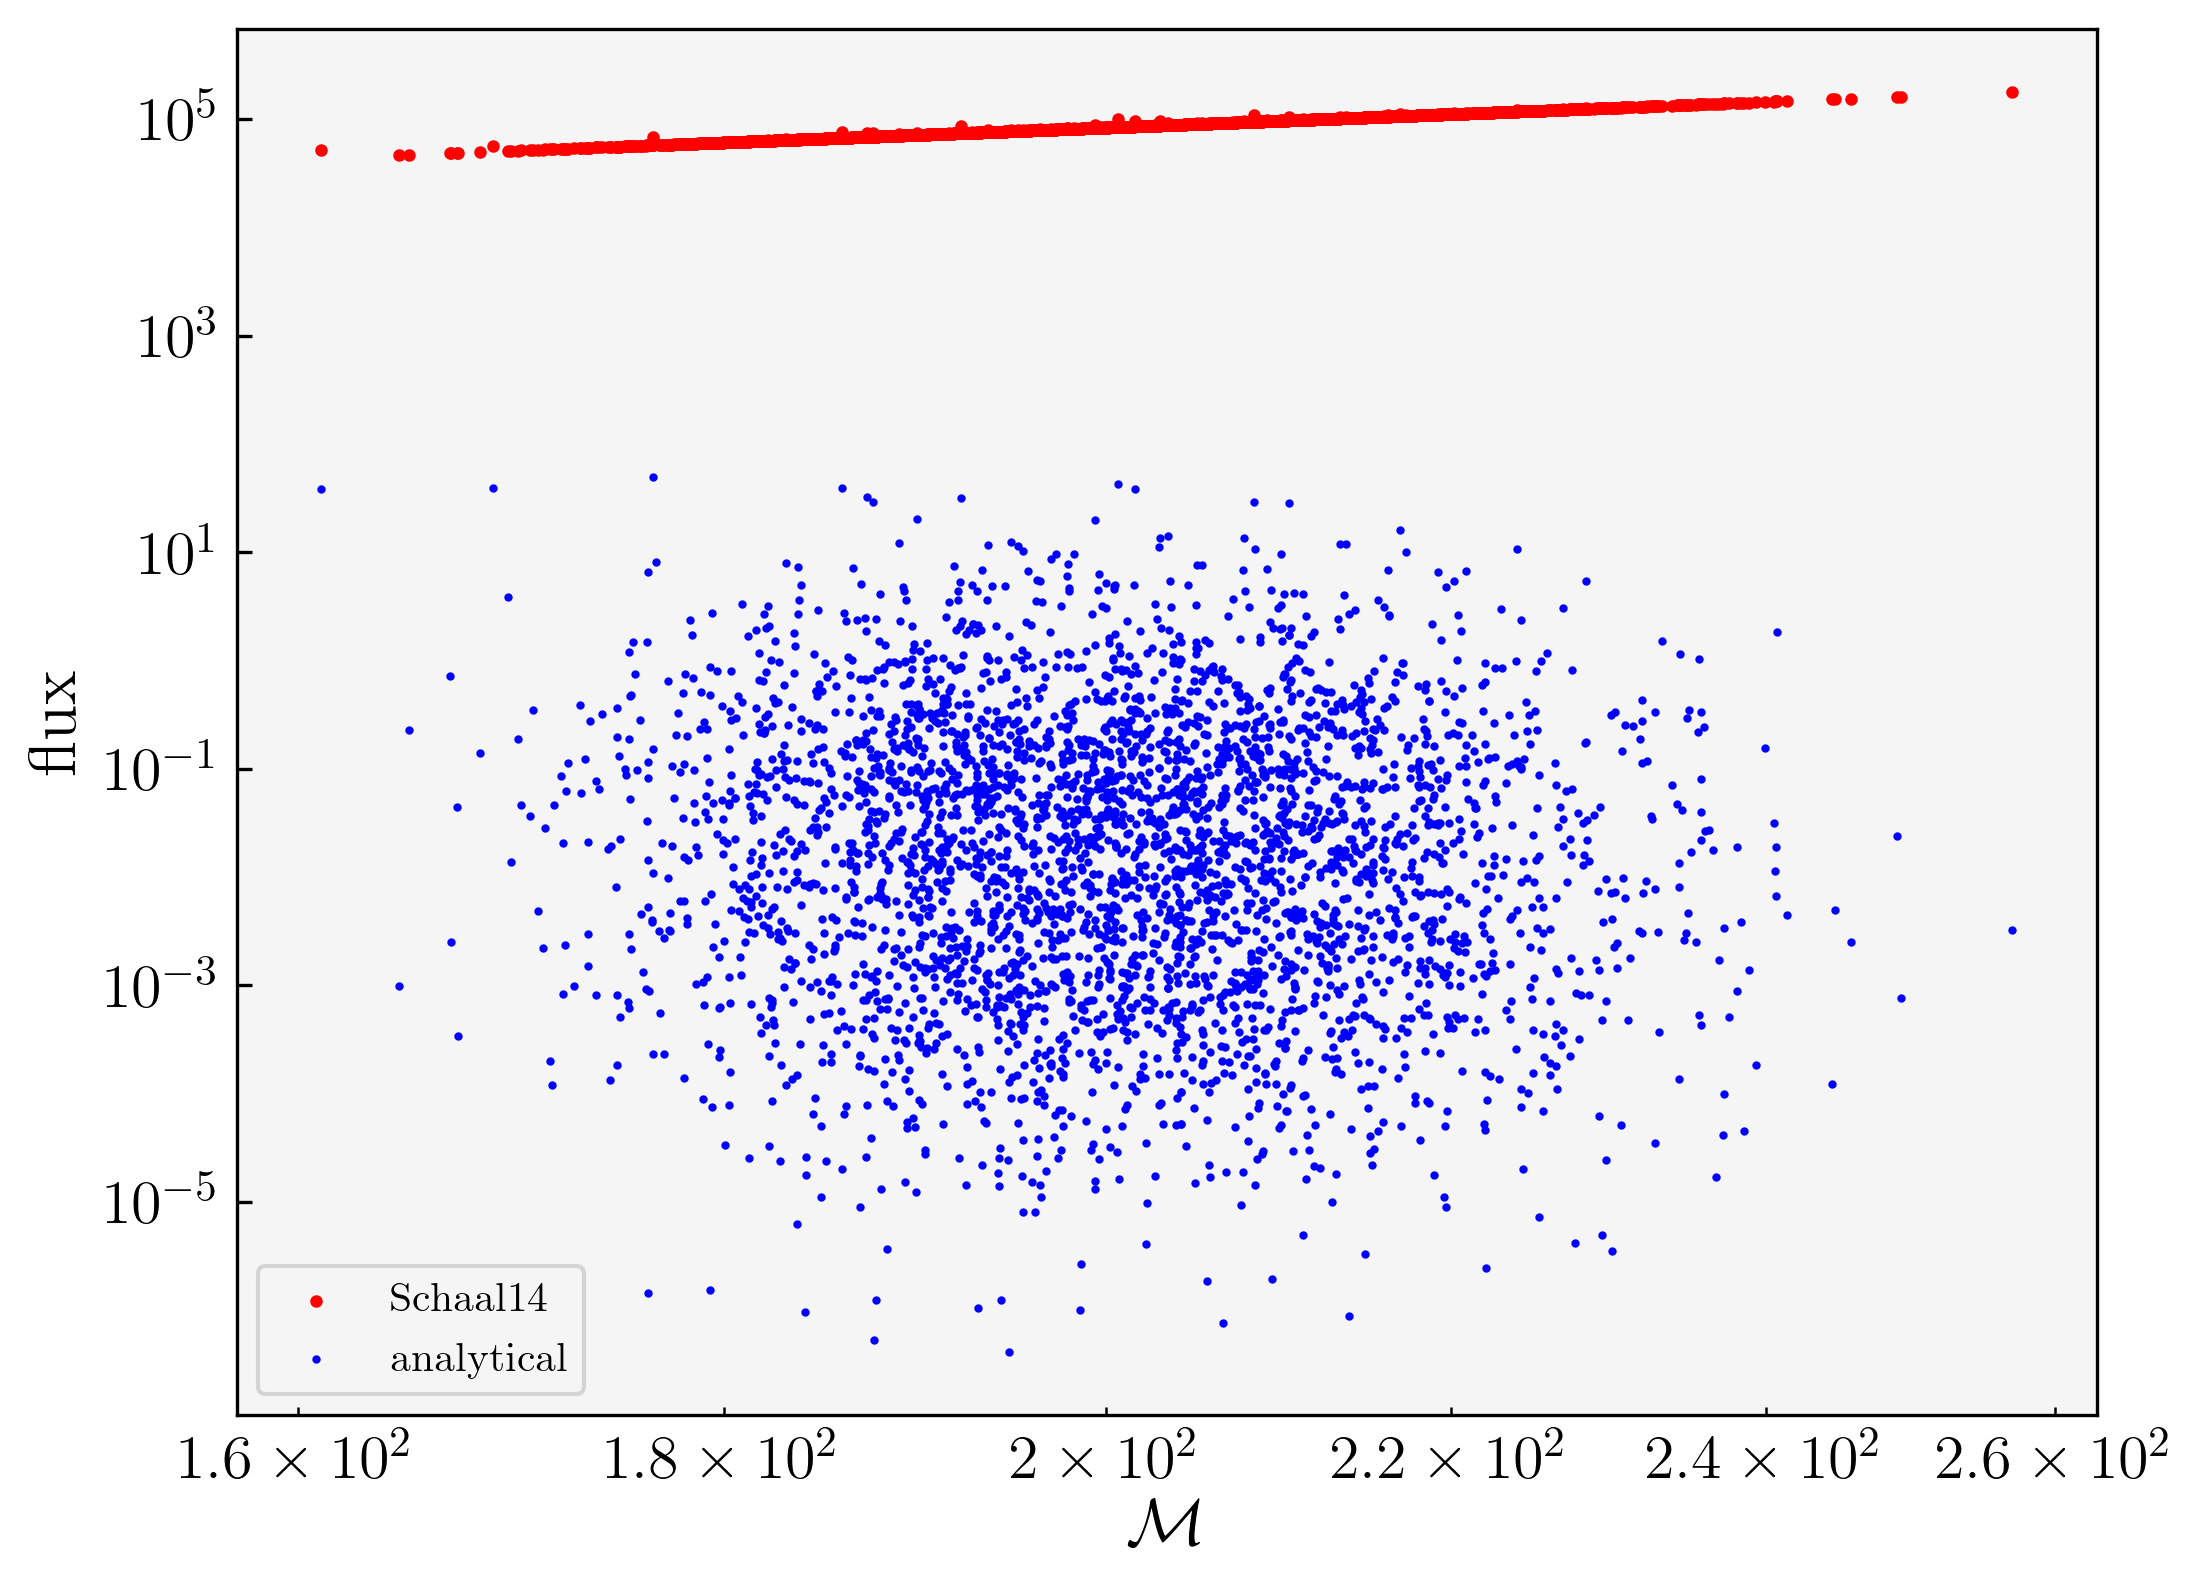

In [75]:
if folder == 'sedov':
    plt.scatter(mach_shock, flux, c = 'r', s=4, label = 'Schaal14')
    plt.scatter(mach_shock, an_flux, c = 'b', s=1, label = 'analytical')
    plt.loglog()
    #plt.xlim(10,1000)
    #plt.ylim(1,1e8)
    plt.xlabel(r'$\mathcal{M}$', fontsize = 16)
    plt.ylabel('flux', fontsize = 16)
    plt.legend()

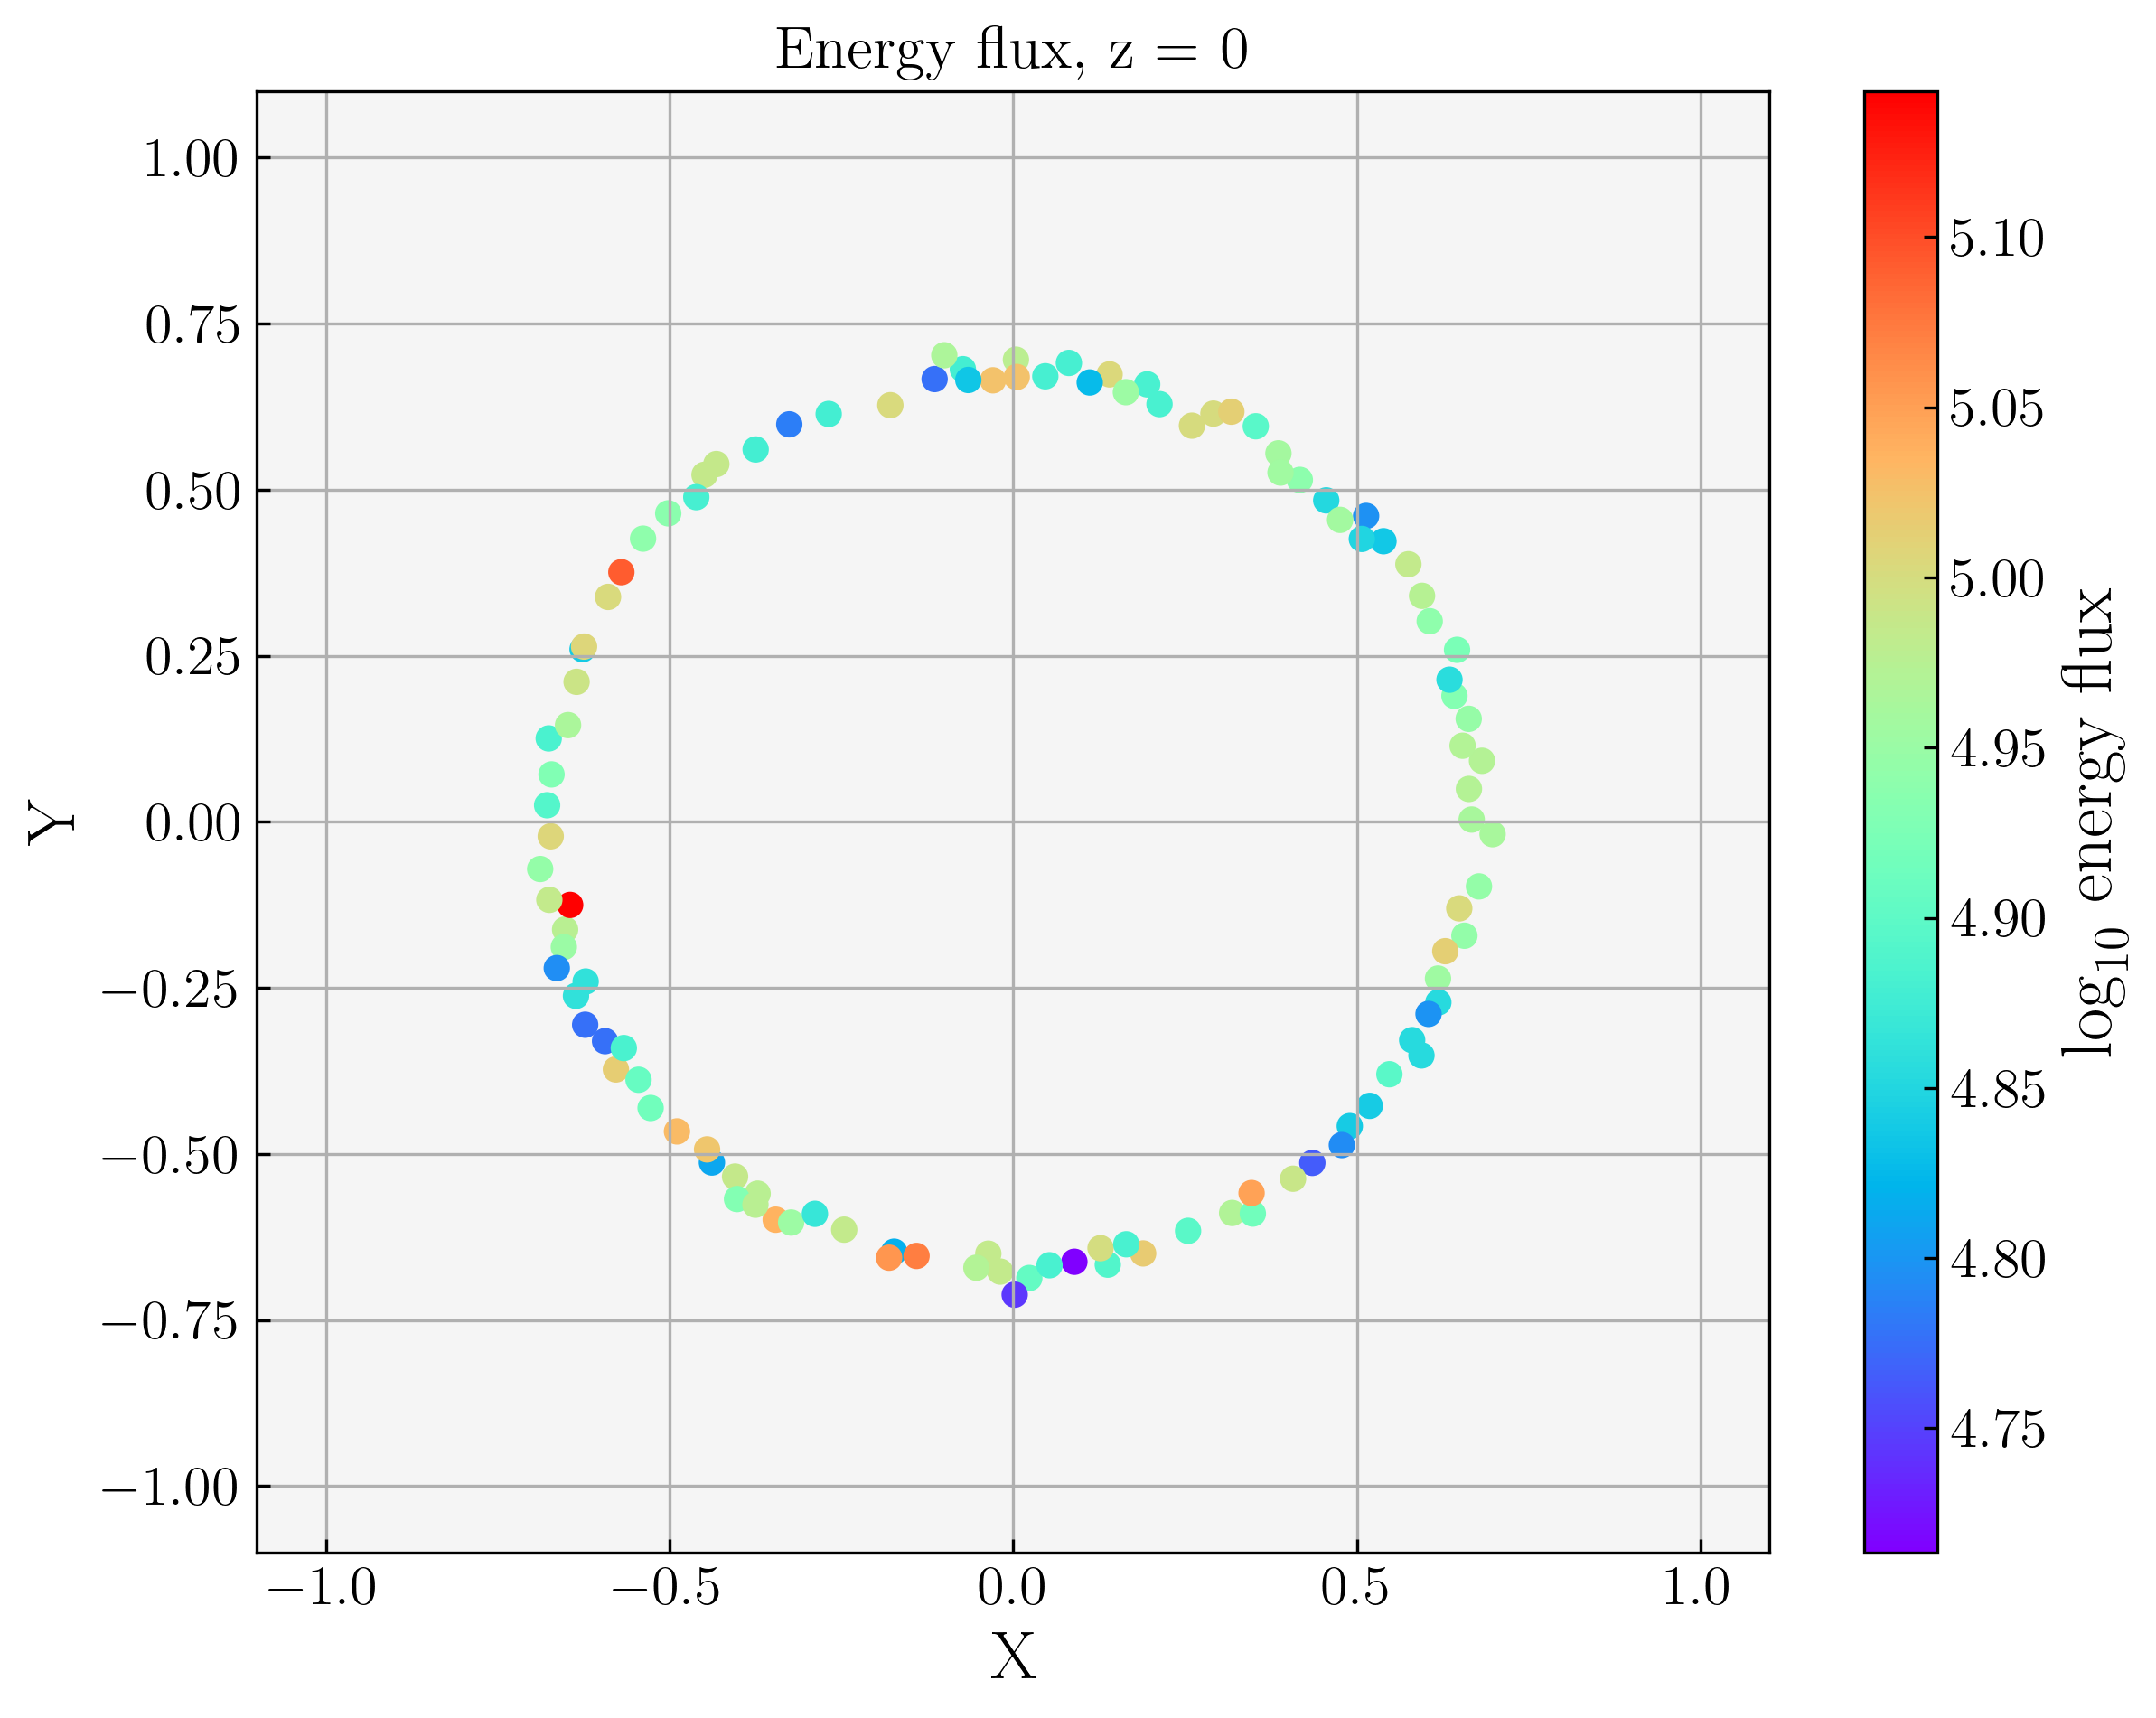

In [76]:
if folder == 'sedov':
    fig, ax = plt.subplots(1,1, figsize = (9,7))
    img = ax.scatter(surface_cross_x, surface_cross_y, c = np.log10(flux_cross), cmap = 'rainbow')
    cbar = plt.colorbar(img)
    cbar.set_label(r'$\log_{10}$ energy flux', fontsize = 19)
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    plt.grid()
    ax.set_title(f'Energy flux, z = {z_chosen}', fontsize = 16)


In [77]:
if folder == 'TDE':
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    ax.set_xlabel(r'X [x/R$_\odot$]', fontsize = 14)
    ax.set_ylabel(r'Y [y/R$_\odot$]', fontsize = 14)
    img = ax.scatter(x_surf, y_surf, c = flux, s = 10, cmap = 'jet', vmin = -1e-6, vmax = 1e-6)
    cb = plt.colorbar(img)
    cb.set_label(r'Flux', fontsize = 14)
    ax.set_xlim(3,46)
    ax.set_ylim(-16,21)
    plt.grid()
    plt.title(f'Cross section, z = {z_chosen}')
